In [1]:
import pickle
from pathlib import Path
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import cv2
import numpy as np
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
def histogram_equalization(image):
    # 直方图均衡化
    return cv2.equalizeHist(image)

def histogram_matching(source_image, reference_image):
    # 计算源图像和参考图像的直方图
    source_hist, bins = np.histogram(source_image.flatten(), 256, [0,256])
    reference_hist, _ = np.histogram(reference_image.flatten(), 256, [0,256])

    # 计算累积分布函数
    source_cdf = source_hist.cumsum()
    reference_cdf = reference_hist.cumsum()

    # 创建一个映射表，以最接近的累积分布函数值映射源图像的亮度值
    hist_map = np.interp(source_cdf, reference_cdf, np.arange(256))

    # 应用映射表来创建匹配后的图像
    matched_image = hist_map[source_image]

    return matched_image.astype(np.uint8)

def adjust_histograms(image_lists):
    # 从所有图像中计算一个平均图像作为参考
    all_images = [image for sublist in image_lists for image in sublist]
    average_image = np.mean(all_images, axis=0).astype(np.uint8)
    
    # 对平均图像应用直方图均衡化
    reference_image = histogram_equalization(average_image)
    
    # 初始化校正后的图像列表
    adjusted_lists = []
    
    # 对每个图像进行直方图匹配
    for sublist in image_lists:
        adjusted_sublist = []
        for image in sublist:
            # 应用直方图匹配
            adjusted_image = histogram_matching(image, reference_image)
            adjusted_sublist.append(adjusted_image)
        adjusted_lists.append(adjusted_sublist)
    
    return adjusted_lists

In [3]:


def extract_certain_subarray(array_256, where = 42):
    if array_256.shape != (256, 256):
        raise ValueError("Input array must be 256x256 in size.")

    # 计算可能的最大起始索引位置
    max_index = 256 - 32

    # 随机生成子数组的左上角起始位置
    start_row = 42
    start_col = 42

    # 从随机位置切片出32x32的子数组
    return array_256[start_row:start_row+32, start_col:start_col+32]




def extract_random_subarray_with_mask(array_256, size = 32):
    if array_256.shape != (256, 256):
        raise ValueError("Input array must be 256x256 in size.")

    # 计算可能的最大起始索引位置
    max_index = 256 - size

    # 随机生成子数组的左上角起始位置
    start_row = np.random.randint(0, max_index + 1)
    start_col = np.random.randint(0, max_index + 1)

    # 创建一个全黑的遮罩数组
    mask = np.zeros_like(array_256)

    # 将选中的子数组区域复制到遮罩中对应位置
    mask[start_row:start_row+size, start_col:start_col+size] = array_256[start_row:start_row+size, start_col:start_col+size]

    return mask


def extract_certain_subarray_with_mask(array_256, row = 0, col = 0, size = 100):
    if array_256.shape != (256, 256):
        raise ValueError("Input array must be 256x256 in size.")

    # 计算可能的最大起始索引位置
    max_index = 256 - size

    # 随机生成子数组的左上角起始位置
    start_row = row
    start_col = col

    # 创建一个全黑的遮罩数组
    mask = np.zeros_like(array_256)

    # 将选中的子数组区域复制到遮罩中对应位置
    mask[start_row:start_row+size, start_col:start_col+size] = array_256[start_row:start_row+size, start_col:start_col+size]

    return mask


In [4]:
def pick_first(loaded_list):
    new_list = []
    for item in loaded_list:
        try:
            number = int(item[0])
            new_list.append(number)
        except:
            new_list.append(-1)
    return new_list

def dicom_image_to_np(filepath): # this one is for simple preprocess
    dcm = pydicom.dcmread(filepath)
    image_data = dcm.pixel_array
    resized_image = cv2.resize(image_data, (256,256)) 
    normalized_image = resized_image / 255.0
    return np.array(normalized_image)

def cover_sides(img, cover_width=50):
    if cover_width < 0 or cover_width > img.shape[1] // 2:
        raise ValueError("cover_width must be between 0 and half of the image width.")
    
    modified_img = img.copy()
    modified_img[:, :cover_width] = 0 
    modified_img[:, -cover_width:] = 0  
    
    return modified_img

def cover_middle(img, cover_width=50):
    if cover_width < 0 or cover_width > img.shape[1]:
        raise ValueError("cover_width must be between 0 and the image width.")
    
    modified_img = img.copy()
    start = (img.shape[1] - cover_width) // 2
    end = start + cover_width
    
    modified_img[:, start:end] = 0
    
    return modified_img

def draw_CR(image_data):
    
    plt.imshow(image_data, cmap='gray') 
    plt.axis('off')
    plt.show()

In [5]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    if image.dtype != np.uint8:
        image = np.uint8(image)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

# Gaussian Blur
def apply_gaussian_blur(image, kernel_size=(5, 5), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma)

# Median Filtering
def apply_median_filter(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def enhance_image_signal(image):
    if image.dtype != np.uint8:
        image = np.uint8(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    blurred_image = cv2.GaussianBlur(clahe_image, (5, 5), 0)
    
    return blurred_image

def apply_rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

In [6]:
name_list = ["INTER_AREA","INTER_LINEAR", "INTER_CUBIC","INTER_LANCZOS4","INTER_NEAREST"]
name = name_list[3]
base_zip_1 = './data/zip_lists_9999_'+name+".pkl"
base_zip_2 = './data/zip_lists_15000_'+name+".pkl"
base_image_1 = './data/image_lists_9999_'+name+".pkl"
base_image_2 = './data/image_lists_15000_'+name+".pkl"
with open(base_zip_1, 'rb') as f:
    dic_load_list_1 = pickle.load(f)

with open(base_image_1, 'rb') as f:
    image_load_list_1 = pickle.load(f)
        
with open(base_zip_2, 'rb') as f:
    dic_load_list_2 = pickle.load(f)

with open(base_image_2, 'rb') as f:
    image_load_list_2 = pickle.load(f)
    
dic_load_list = dic_load_list_1 + dic_load_list_2
image_load_list = image_load_list_1 + image_load_list_2

In [7]:
zip_load_list = []
for item in dic_load_list:
    zip_load_list.append(item['zip'])

In [8]:
zip_filt_list = pick_first(zip_load_list)

In [9]:
Counter(zip_filt_list)

Counter({9: 4227,
         4: 2003,
         0: 1689,
         1: 1459,
         8: 273,
         7: 198,
         2: 73,
         -1: 59,
         5: 3,
         3: 2,
         6: 1})

In [10]:
zip_load_list = []
three_load_list = []
for item in dic_load_list:
    zip_load_list.append(item['zip'])
    try:
        three_load_list.append([int(item['Exposure']), int(item['ExposureInuAs']), int(item['ExposureTime']), int(item['XRayTubeCurrent'])])
    except:
        three_load_list.append([0,0,0,0])

In [39]:
def find_dcm_files(directory):
    root_dir = Path(directory)
    dcm_files = root_dir.rglob('*.dcm')
    dcm_file_paths = [str(file) for file in dcm_files]
    
    return dcm_file_paths
def display_dicom_image(filepath):
    dcm = pydicom.dcmread(filepath)
    image_data = dcm.pixel_array
    #resized_image = cv2.resize(image_data, (256,256)) 
    resized_image = cv2.resize(image_data, (256,256),interpolation=cv2.INTER_CUBIC) 
    normalized_image = resized_image / 255.0
    
    return np.array(normalized_image)
file_list = find_dcm_files('./mimic_cxr/')
df = pd.read_csv('./mimic_cxr4.csv')
df = df.set_index('dicom')
setting_pred_lsit = []
image_pred_list = []
mimic_label = []
mimic_image = []
for file_path in file_list:
    image_now = display_dicom_image(file_path)
    parameters = [df.loc[file_path.split('/')[-1][:-4]]['Exposure'],df.loc[file_path.split('/')[-1][:-4]]['ExposureInuAs'],df.loc[file_path.split('/')[-1][:-4]]['ExposureTime'],df.loc[file_path.split('/')[-1][:-4]]['XRayTubeCurrent']]
    image_pred_list.append(image_now)
    setting_pred_lsit.append(parameters)
    mimic_label.append(3)
    mimic_image.append(image_now)

In [40]:
zip_list = []
image_list = []
four = []
one = []
nine = []
four_zip = []
one_zip = []
nine_zip = []
three_list = []
for i in range(len(zip_filt_list)):
    if (zip_filt_list[i] == 4 or zip_filt_list[i] == 9 or zip_filt_list[i] == 1) and three_load_list[i]!= [0,0,0,0]:
        if zip_filt_list[i] == 4:
            zip_list.append(0)
            four_zip.append(0)
            four.append(np.uint8(image_load_list[i]))
        if zip_filt_list[i] == 1: 
            zip_list.append(1)
            one_zip.append(1)
            one.append(np.uint8(image_load_list[i]))
        if zip_filt_list[i] == 9:
            zip_list.append(2)
            nine_zip.append(2)
            nine.append(np.uint8(image_load_list[i]))
        three_list.append(three_load_list[i])
        image_list.append( np.uint8(image_load_list[i]))
print(len(zip_list), len(image_list))

7401 7401


In [41]:
image_list+=image_pred_list
zip_list+=mimic_label
three_list+=setting_pred_lsit
print(len(zip_list), len(image_list))

8901 8901


In [42]:
print(len(three_list))

8901


In [43]:
Counter(zip_list)

Counter({2: 4223, 0: 1775, 3: 1500, 1: 1403})

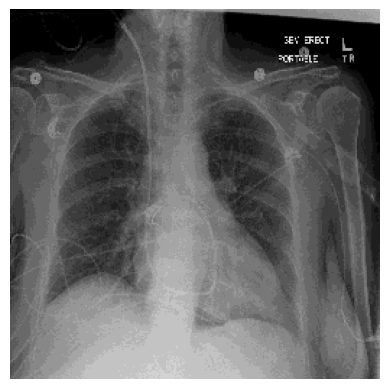

In [17]:

draw_CR(image_list[0])

In [53]:
X = np.array(image_list) 
X = X.reshape((-1, 256, 256, 1)) 
y = to_categorical(zip_list, num_classes=4)  

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [47]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
y = to_categorical(zip_list, num_classes=4) 
X = np.array(three_list) 
X_train_exp, X_temp_exp, _, _ = train_test_split(X, y, test_size=0.3, random_state=42)
X_val_exp, X_test_exp, _, _ = train_test_split(X_temp_exp, y_temp, test_size=0.5, random_state=42)
scaler = StandardScaler()

In [48]:
X_train_exp = scaler.fit_transform(X_train_exp)
X_val_exp = scaler.transform(X_val_exp)
X_test_exp = scaler.transform(X_test_exp)

# ResNet50

In [54]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

def build_model(input_shape=(256, 256, 1), num_classes=4):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    base_model.trainable = False

    model = models.Sequential([
        layers.experimental.preprocessing.Resizing(224, 224),
        layers.Conv2D(3, (3, 3), padding='same'),  
        base_model,         
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model_ResNet50 = build_model()
model_ResNet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
from tensorflow.keras.models import load_model
model_ResNet50 = load_model('./image_models/model_ResNet50INTER_LANCZOS4')

In [66]:
model_ResNet50.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val))

test_loss, test_acc = model_ResNet50.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/2
195/195 [==============================] - 478s 2s/step - loss: 0.3922 - accuracy: 0.8530 - val_loss: 0.3371 - val_accuracy: 0.8577
Epoch 2/2
42/42 [==============================] - 33s 792ms/step - loss: 0.3098 - accuracy: 0.8855
Test accuracy: 0.8855


In [67]:

test_loss, test_acc = model_ResNet50.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

42/42 [==============================] - 33s 791ms/step - loss: 0.3098 - accuracy: 0.8855
Test accuracy: 0.8855


In [43]:
from tensorflow.keras.models import load_model 
model_ResNet50.save('./image_models/model_ResNet50'+name)  

INFO:tensorflow:Assets written to: ./image_models/model_ResNet50INTER_LANCZOS4/assets


INFO:tensorflow:Assets written to: ./image_models/model_ResNet50INTER_LANCZOS4/assets


In [68]:

y_pred = np.argmax(model_ResNet50.predict(X_test), axis=1)
y_test_n = np.argmax(y_test, axis=1)

42/42 [==============================] - 34s 801ms/step


[[227  16  13   9]
 [  6 131  59   9]
 [  4  13 632   8]
 [  5   4   7 193]]


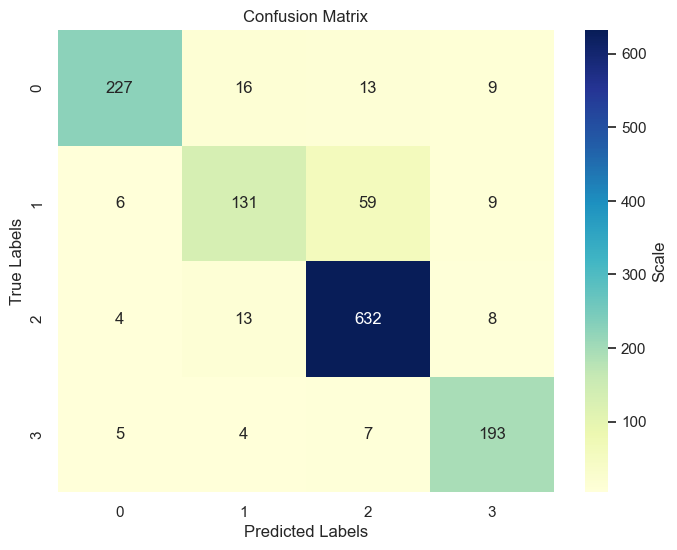

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    # 計算混淆矩陣
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    # 使用Seaborn畫出混淆矩陣
    sns.set(color_codes=True)
    plt.figure(1, figsize=(8, 6))
    
    plt.title("Confusion Matrix")
    
    sns.heatmap(cm, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'}, fmt='g')
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    
    plt.show()

plot_confusion_matrix(y_test_n, y_pred)

# CREATE FAKE LIST

In [70]:
def remove_indices(origin_list, indices):

    return [item for idx, item in enumerate(origin_list) if idx not in indices]

In [69]:
def remove_indices(origin_list, indices):

    return [item for idx, item in enumerate(origin_list) if idx not in indices]
indices = [i for i, (true, pred) in enumerate(zip(y_test_n, y_pred)) if true == 2 and pred == 1]

In [110]:
print(indices)

[27, 72, 91, 100, 171, 189, 192, 222, 235, 260, 293, 325, 389, 520, 637, 650, 662, 711, 738, 787, 819, 834, 837, 849, 910, 933, 950, 1034, 1040]


In [72]:
remove_y_test = remove_indices(y_test_n,indices)
remove_y_pred = remove_indices(y_pred,indices)

# exposure model

## SVM

In [19]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# 創建SVM分類器
svm_model =SVC(C=1, kernel='linear', probability=True, random_state=22)

# 訓練模型
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
svm_model.fit(X_train_exp, y_train_labels)
y_pred = svm_model.predict(X_test_exp)

test_acc = accuracy_score(y_test_labels, y_pred)
print(f"測試集上的準確率: {test_acc}")


測試集上的準確率: 0.7866786678667866


[[231   0   0]
 [  0 237   0]
 [  0   0 643]]


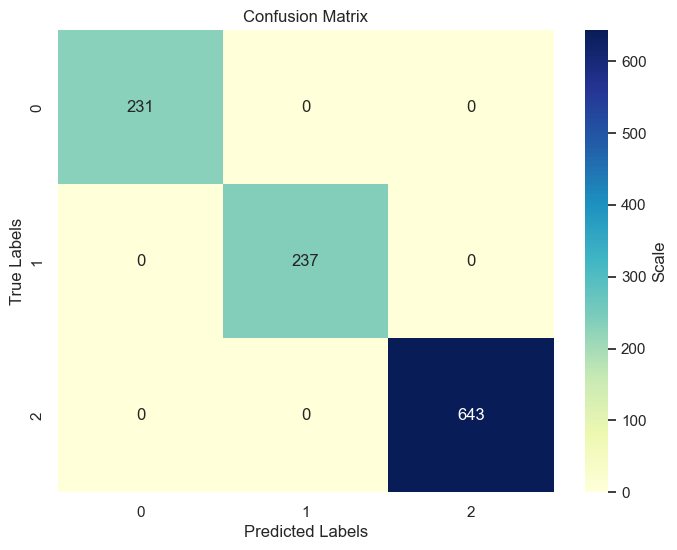

In [27]:
plot_confusion_matrix(y_pred, y_pred)

# RF

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# 創建隨機森林分類器
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)

# 訓練模型
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
rf_model.fit(X_train_exp, y_train_labels)
y_pred = rf_model.predict(X_test_exp)

test_acc = accuracy_score(y_test_labels, y_pred)
print(f"測試集上的準確率: {test_acc}")


測試集上的準確率: 0.9416167664670658


In [68]:
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

/opt/miniconda3/envs/MIT_test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/MIT_test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23565 (\N{CJK UNIFIED IDEOGRAPH-5C0D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/MIT_test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/MIT_test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/MIT_test/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24615 (\N{CJK UNIFIED I

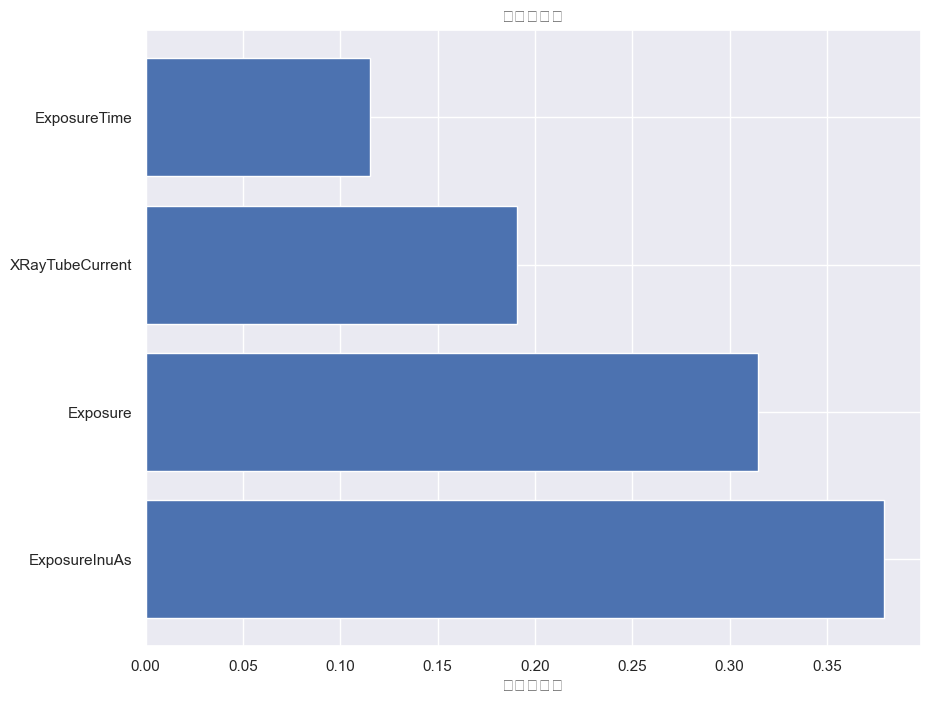

In [60]:
import matplotlib.pyplot as plt

# 獲取特徵重要性
feature_importances = rf_model.feature_importances_

# 將特徵重要性與特徵名稱相結合並排序
features = np.array(['ExposureTime', 'XRayTubeCurrent', 'Exposure', 'ExposureInuAs']) # 替換成你的特徵名稱
importances = sorted(zip(feature_importances, features), reverse=True)

# 繪製特徵重要性
plt.figure(figsize=(10, 8))
plt.title("特徵重要性")
plt.barh(range(len(importances)), [i[0] for i in importances], color='b', align='center')
plt.yticks(range(len(importances)), [i[1] for i in importances])
plt.xlabel('相對重要性')
plt.show()


In [61]:
for i in range(10):
    print(X_test_exp[i])

[ 0.05567151  0.0677473  -0.10699619  0.35238253]
[-0.31726776 -0.53874567 -0.37005314  1.89805866]
[ 0.80155005  0.75005188  0.33143204 -1.00008409]
[-0.31726776 -0.38712243 -0.28236749  0.39102443]
[ 0.42861078  0.37099378 -0.10699619  1.89805866]
[-0.31726776 -0.38712243 -0.28236749  0.39102443]
[ 0.42861078  0.56052283  0.2437464  -1.00008409]
[-0.31726776 -0.42502824 -0.28236749  0.35238253]
[ 0.05567151 -0.08387594 -0.15083902  0.35238253]
[-0.69020703 -0.61455729 -0.28236749 -1.00008409]


In [63]:
three_load_list.append([int(item['Exposure']), int(item['ExposureInuAs']), int(item['ExposureTime']), int(item['XRayTubeCurrent'])])

IndexError: list index out of range

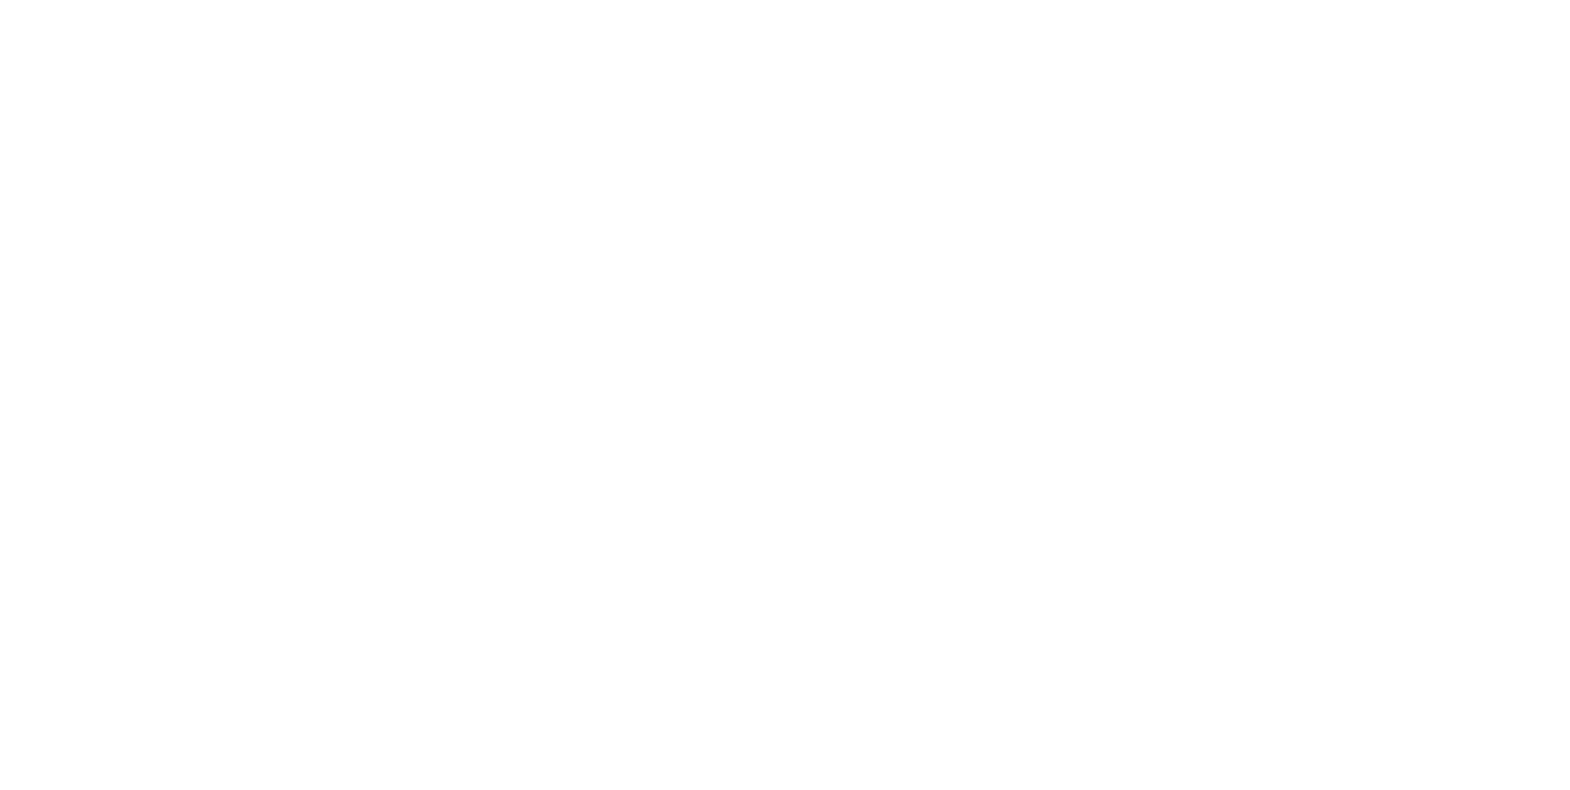

In [64]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 選擇隨機森林中的一棵樹
estimator = rf_model.estimators_[0]  # 更改索引以查看其他樹

# 繪製決策樹
plt.figure(figsize=(20, 10))
plot_tree(estimator, 
          filled=True, 
          feature_names=['Exposure', 'ExposureInuAs', 'ExposureTime', 'XRayTubeCurrent'], # 替換成你的特徵名稱
          class_names=['MI', 'PA', 'CA'])  # 替換成你的類別名稱
plt.show()


In [31]:
import shap

# 初始化SHAP解釋器
explainer = shap.TreeExplainer(rf_model)

# 計算SHAP值
shap_values = explainer.shap_values(X_test_exp)  # X_test_exp是你的測試集數據

# 繪製單個預測的SHAP值
shap.initjs()  # 初始化JS可視化
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test_exp.iloc[0,:])  # 更改索引來查看不同的預測


ModuleNotFoundError: No module named 'shap'

[[221  32   0  12]
 [  9 191   0   5]
 [  5   1 646   5]
 [  7   2   0 200]]


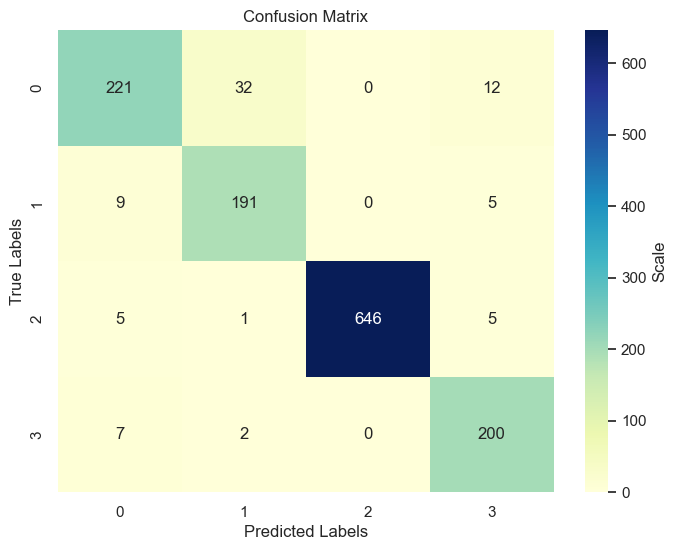

In [65]:
plot_confusion_matrix(y_test_labels, y_pred)

# NN

In [59]:
import tensorflow as tf
from tensorflow.keras import layers, models
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(4,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))  # 3個輸出對應於3個類別

# 編譯模型
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
model.fit(X_train_exp ,y_train, epochs=40, validation_split=0.2)
test_loss, test_acc = model.evaluate(X_test_exp, y_test)
print(f"測試集上的損失: {test_loss}, 測試集上的準確率: {test_acc}")

Epoch 1/40
130/130 [==============================] - 0s 618us/step - loss: 0.2700 - accuracy: 0.9114 - val_loss: 0.2962 - val_accuracy: 0.8591
Epoch 2/40
130/130 [==============================] - 0s 489us/step - loss: 0.2690 - accuracy: 0.9146 - val_loss: 0.3122 - val_accuracy: 0.8504
Epoch 3/40
130/130 [==============================] - 0s 510us/step - loss: 0.2622 - accuracy: 0.9155 - val_loss: 0.3036 - val_accuracy: 0.8523
Epoch 4/40
130/130 [==============================] - 0s 507us/step - loss: 0.2641 - accuracy: 0.9167 - val_loss: 0.3164 - val_accuracy: 0.8523
Epoch 5/40
130/130 [==============================] - 0s 503us/step - loss: 0.2539 - accuracy: 0.9213 - val_loss: 0.2871 - val_accuracy: 0.9151
Epoch 6/40
130/130 [==============================] - 0s 499us/step - loss: 0.2542 - accuracy: 0.9240 - val_loss: 0.2872 - val_accuracy: 0.9141
Epoch 7/40
130/130 [==============================] - 0s 495us/step - loss: 0.2508 - accuracy: 0.9286 - val_loss: 0.2800 - val_accuracy:

In [103]:
def remove_indices(origin_list, indices):
    # 假設 origin_list 是一個NumPy數組
    return np.delete(origin_list, indices, axis=0)
remove_X_test_exp = remove_indices(X_test_exp,indices)

In [104]:
y_pred_exp = np.argmax(model.predict(X_test_exp), axis=1)
y_test_n_exp = np.argmax(y_test, axis=1)
remove_y_test_n_exp = remove_indices(y_test_n_exp,indices)

35/35 [==============================] - 0s 358us/step


In [105]:
remove_y_pred_exp = np.argmax(model.predict(remove_X_test_exp), axis=1)

34/34 [==============================] - 0s 316us/step


測試集上的準確率: 0.9216921692169217
[[193  57   4]
 [ 16 191   2]
 [  5   3 640]]


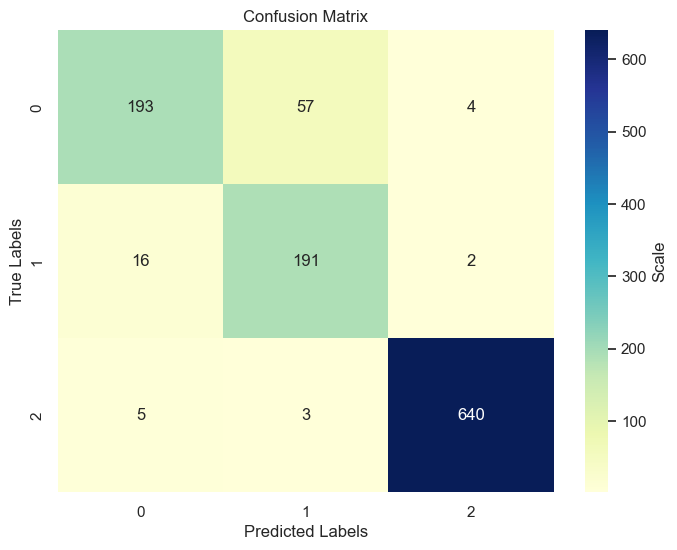

測試集上的準確率: 0.9195933456561922
[[193  57   4]
 [ 16 191   2]
 [  5   3 611]]


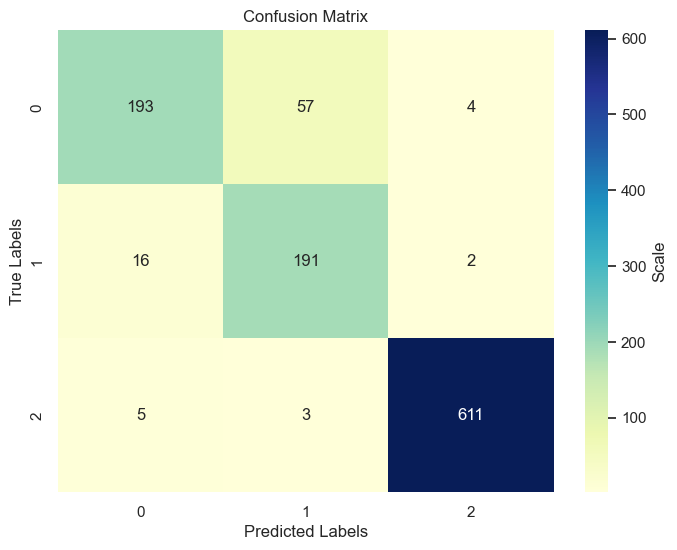

In [111]:
test_acc = accuracy_score(y_test_n_exp, y_pred_exp)
print(f"測試集上的準確率: {test_acc}")
plot_confusion_matrix(y_test_n_exp, y_pred_exp)

test_acc = accuracy_score(remove_y_test_n_exp, remove_y_pred_exp)
print(f"測試集上的準確率: {test_acc}")
plot_confusion_matrix(remove_y_test_n_exp, remove_y_pred_exp)

# Final experiment

In [53]:
fake_y_train = model.predict(X_train_exp)
fake_y_val = model.predict(X_val_exp)
fake_y_test = model.predict(X_test_exp)

35/35 [==============================] - 0s 274us/step


In [54]:
model_ResNet50_fake = build_model()
model_ResNet50_fake.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
model_ResNet50_fake.fit(X_train, fake_y_train, epochs=8, validation_data=(X_val, fake_y_val))

test_loss, test_acc = model_ResNet50.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/8
162/162 [==============================] - 407s 3s/step - loss: 0.9131 - accuracy: 0.6757 - val_loss: 0.7873 - val_accuracy: 0.7523
Epoch 2/8
162/162 [==============================] - 392s 2s/step - loss: 0.7819 - accuracy: 0.7790 - val_loss: 0.7420 - val_accuracy: 0.8243
Epoch 3/8
162/162 [==============================] - 392s 2s/step - loss: 0.7435 - accuracy: 0.8106 - val_loss: 0.7231 - val_accuracy: 0.8189
Epoch 4/8
162/162 [==============================] - 391s 2s/step - loss: 0.7275 - accuracy: 0.8224 - val_loss: 0.7201 - val_accuracy: 0.8468
Epoch 5/8
162/162 [==============================] - 392s 2s/step - loss: 0.7110 - accuracy: 0.8342 - val_loss: 0.7152 - val_accuracy: 0.8234
Epoch 6/8
 60/162 [==========>...................] - ETA: 3:52 - loss: 0.6857 - accuracy: 0.8469

KeyboardInterrupt: 

# Loop model


In [11]:
name_list = ["INTER_AREA","INTER_LINEAR", "INTER_CUBIC","INTER_LANCZOS4","INTER_NEAREST"]
for name in name_list:
    print("now: "+name)
    base_zip_1 = './data/zip_lists_9999_'+name+".pkl"
    base_zip_2 = './data/zip_lists_15000_'+name+".pkl"
    base_image_1 = './data/image_lists_9999_'+name+".pkl"
    base_image_2 = './data/image_lists_15000_'+name+".pkl"
    with open(base_zip_1, 'rb') as f:
        dic_load_list_1 = pickle.load(f)

    with open(base_image_1, 'rb') as f:
        image_load_list_1 = pickle.load(f)
            
    with open(base_zip_2, 'rb') as f:
        dic_load_list_2 = pickle.load(f)

    with open(base_image_2, 'rb') as f:
        image_load_list_2 = pickle.load(f)
        
    dic_load_list = dic_load_list_1 + dic_load_list_2
    image_load_list = image_load_list_1 + image_load_list_2
    zip_load_list = []
    for item in dic_load_list:
        zip_load_list.append(item['zip'])
    zip_filt_list = pick_first(zip_load_list)
    zip_list = []
    image_list = []
    four = []
    one = []
    nine = []
    four_zip = []
    one_zip = []
    nine_zip = []
    for i in range(len(zip_filt_list)):
        if zip_filt_list[i] == 4 or zip_filt_list[i] == 9 or zip_filt_list[i] == 1:
            if zip_filt_list[i] == 4:
                zip_list.append(0)
                four_zip.append(0)
                four.append(np.uint8(image_load_list[i]))
            if zip_filt_list[i] == 1:
                zip_list.append(1)
                one_zip.append(1)
                one.append(np.uint8(image_load_list[i]))
            if zip_filt_list[i] == 9:
                zip_list.append(2)
                nine_zip.append(2)
                nine.append(np.uint8(image_load_list[i]))
            image_list.append( np.uint8(image_load_list[i]))
    print(len(zip_list), len(image_list))
    
    X = np.array(image_list) 
    X = X.reshape((-1, 256, 256, 1)) 
    y = to_categorical(zip_list, num_classes=3)  

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    model_ResNet50 = build_model()
    model_ResNet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model_ResNet50.fit(X_train, y_train, epochs=4, validation_data=(X_val, y_val))

    test_loss, test_acc = model_ResNet50.evaluate(X_test, y_test)
    print("====="+name+"=====")
    print(f"Test accuracy: {test_acc:.4f}")
    model_ResNet50.save('./models/model_resnet50_v2_'+name)  

now: INTER_AREA
7689 7689
Epoch 1/4
169/169 [==============================] - 412s 2s/step - loss: 0.6767 - accuracy: 0.7215 - val_loss: 0.3997 - val_accuracy: 0.8448
Epoch 2/4
169/169 [==============================] - 416s 2s/step - loss: 0.4502 - accuracy: 0.8194 - val_loss: 0.3464 - val_accuracy: 0.8621
Epoch 3/4
169/169 [==============================] - 417s 2s/step - loss: 0.3790 - accuracy: 0.8480 - val_loss: 0.2942 - val_accuracy: 0.8873
Epoch 4/4
37/37 [==============================] - 28s 768ms/step - loss: 0.3134 - accuracy: 0.8718
=====INTER_AREA=====
Test accuracy: 0.8718
INFO:tensorflow:Assets written to: ./models/model_resnet50_v2_INTER_AREA/assets


INFO:tensorflow:Assets written to: ./models/model_resnet50_v2_INTER_AREA/assets


now: INTER_LINEAR
7689 7689
Epoch 1/4
169/169 [==============================] - 410s 2s/step - loss: 0.8304 - accuracy: 0.6449 - val_loss: 0.6047 - val_accuracy: 0.7615
Epoch 2/4
169/169 [==============================] - 407s 2s/step - loss: 0.5163 - accuracy: 0.7969 - val_loss: 0.3672 - val_accuracy: 0.8560
Epoch 3/4
169/169 [==============================] - 406s 2s/step - loss: 0.3874 - accuracy: 0.8428 - val_loss: 0.3126 - val_accuracy: 0.8881
Epoch 4/4
37/37 [==============================] - 29s 770ms/step - loss: 0.2828 - accuracy: 0.8856
=====INTER_LINEAR=====
Test accuracy: 0.8856
INFO:tensorflow:Assets written to: ./models/model_resnet50_v2_INTER_LINEAR/assets


INFO:tensorflow:Assets written to: ./models/model_resnet50_v2_INTER_LINEAR/assets


now: INTER_CUBIC
7689 7689
Epoch 1/4
169/169 [==============================] - 408s 2s/step - loss: 0.7478 - accuracy: 0.6884 - val_loss: 0.4571 - val_accuracy: 0.8231
Epoch 2/4
169/169 [==============================] - 405s 2s/step - loss: 0.4618 - accuracy: 0.8172 - val_loss: 0.3604 - val_accuracy: 0.8491
Epoch 3/4
169/169 [==============================] - 406s 2s/step - loss: 0.3554 - accuracy: 0.8579 - val_loss: 0.3160 - val_accuracy: 0.8794
Epoch 4/4
37/37 [==============================] - 29s 771ms/step - loss: 0.2776 - accuracy: 0.8969
=====INTER_CUBIC=====
Test accuracy: 0.8969
INFO:tensorflow:Assets written to: ./models/model_resnet50_v2_INTER_CUBIC/assets


INFO:tensorflow:Assets written to: ./models/model_resnet50_v2_INTER_CUBIC/assets


now: INTER_LANCZOS4
7689 7689
Epoch 1/4
169/169 [==============================] - 410s 2s/step - loss: 0.5572 - accuracy: 0.7735 - val_loss: 0.3460 - val_accuracy: 0.8656
Epoch 2/4
169/169 [==============================] - 411s 2s/step - loss: 0.3745 - accuracy: 0.8504 - val_loss: 0.3030 - val_accuracy: 0.8933
Epoch 3/4
169/169 [==============================] - 407s 2s/step - loss: 0.3115 - accuracy: 0.8781 - val_loss: 0.2653 - val_accuracy: 0.8968
Epoch 4/4
37/37 [==============================] - 28s 753ms/step - loss: 0.2747 - accuracy: 0.8943
=====INTER_LANCZOS4=====
Test accuracy: 0.8943
INFO:tensorflow:Assets written to: ./models/model_resnet50_v2_INTER_LANCZOS4/assets


INFO:tensorflow:Assets written to: ./models/model_resnet50_v2_INTER_LANCZOS4/assets


now: INTER_NEAREST
7689 7689
Epoch 1/4
169/169 [==============================] - 403s 2s/step - loss: 0.6975 - accuracy: 0.7133 - val_loss: 0.4791 - val_accuracy: 0.8205
Epoch 2/4
169/169 [==============================] - 8030s 48s/step - loss: 0.4647 - accuracy: 0.8157 - val_loss: 0.3791 - val_accuracy: 0.8430
Epoch 3/4
169/169 [==============================] - 411s 2s/step - loss: 0.3744 - accuracy: 0.8534 - val_loss: 0.2878 - val_accuracy: 0.8925
Epoch 4/4
37/37 [==============================] - 29s 772ms/step - loss: 0.2893 - accuracy: 0.8873
=====INTER_NEAREST=====
Test accuracy: 0.8873
INFO:tensorflow:Assets written to: ./models/model_resnet50_v2_INTER_NEAREST/assets


INFO:tensorflow:Assets written to: ./models/model_resnet50_v2_INTER_NEAREST/assets


# Experiment

In [92]:
zip_filt_list = pick_first(zip_load_list)
eight_all = []
eight_all_dic = []

ccc = 0
for i in range(len(zip_filt_list)):
    try:
        #print( dic_load_list[i]['ExposureTime'])
        if zip_filt_list[i] == 8 and dic_load_list[i]['ExposureTime']!='10':
            eight_all.append(np.uint8(image_load_list[i]))
            eight_all_dic.append(dic_load_list[i])
    except:
        ccc+=1
        
print(len(eight_all_dic),ccc)

198 0


In [93]:
X = np.array(eight_all) 
X = X.reshape((-1, 256, 256, 1)) 
predc = model_resnet50.predict(X)

7/7 [==============================] - 5s 705ms/step


In [94]:
max_indices = np.argmax(predc, axis=1)

In [95]:
Counter(max_indices)

Counter({0: 115, 1: 54, 2: 29})

In [ ]:
data_list = [
    ["左上100 左下100",0,0,100,156,0,100],
    ["左下100 右上100",156,0,100 ,0,156,100],
    ["右上100 右下100",0,156,100,156,156,100],
    ["右下100 左上100",156,156,100,0,0,100],
    ["中間100",106,106,100],
]
model_list = []
Test_accuracy_list = []

In [17]:
data_list = [
    ["右下128",128,128,128],
    ["左上128 ",0,0,128],
    ["左下128",128,0,128],
    ["右上128",0,128,128],
    ["右下128",128,128,128],
    ["中間128",64,64,128],
]
model_list = []
Test_accuracy_list = []

========== 右下128 ==========


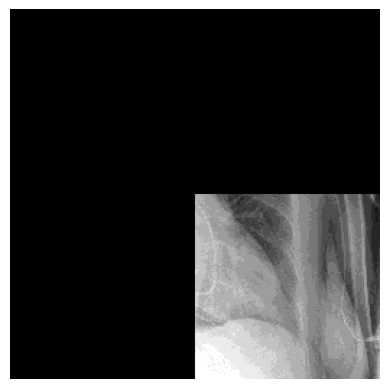

Epoch 1/4
169/169 [==============================] - 414s 2s/step - loss: 0.9105 - accuracy: 0.6013 - val_loss: 0.7997 - val_accuracy: 0.6713
Epoch 2/4
169/169 [==============================] - 409s 2s/step - loss: 0.8046 - accuracy: 0.6607 - val_loss: 0.7449 - val_accuracy: 0.6843
Epoch 3/4
169/169 [==============================] - 409s 2s/step - loss: 0.7741 - accuracy: 0.6709 - val_loss: 0.7480 - val_accuracy: 0.6722
Epoch 4/4
37/37 [==============================] - 29s 778ms/step - loss: 0.7490 - accuracy: 0.6733
Test accuracy: 0.6733
========== 左上128  ==========


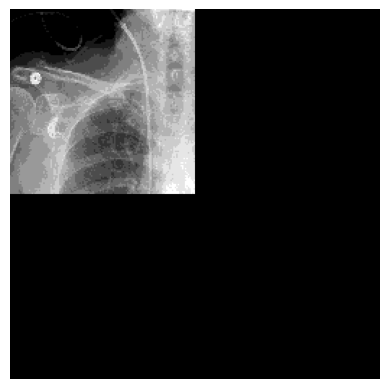

Epoch 1/4
169/169 [==============================] - 408s 2s/step - loss: 0.8279 - accuracy: 0.6492 - val_loss: 0.6824 - val_accuracy: 0.7207
Epoch 2/4
169/169 [==============================] - 404s 2s/step - loss: 0.7009 - accuracy: 0.7079 - val_loss: 0.6070 - val_accuracy: 0.7667
Epoch 3/4
169/169 [==============================] - 404s 2s/step - loss: 0.6505 - accuracy: 0.7280 - val_loss: 0.5613 - val_accuracy: 0.7719
Epoch 4/4
37/37 [==============================] - 29s 792ms/step - loss: 0.5920 - accuracy: 0.7574
Test accuracy: 0.7574
========== 左下128 ==========


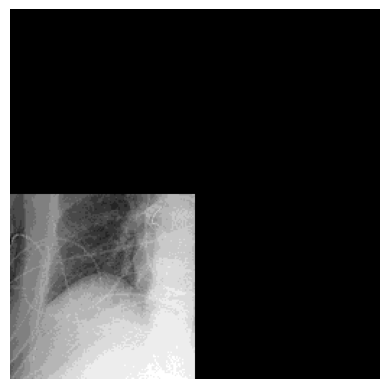

Epoch 1/4
169/169 [==============================] - 486s 3s/step - loss: 0.9426 - accuracy: 0.5873 - val_loss: 0.7972 - val_accuracy: 0.6670
Epoch 2/4
169/169 [==============================] - 536s 3s/step - loss: 0.8250 - accuracy: 0.6451 - val_loss: 0.7540 - val_accuracy: 0.6869
Epoch 3/4
169/169 [==============================] - 525s 3s/step - loss: 0.7935 - accuracy: 0.6563 - val_loss: 0.7066 - val_accuracy: 0.7034
Epoch 4/4
37/37 [==============================] - 39s 1s/step - loss: 0.7365 - accuracy: 0.7106
Test accuracy: 0.7106
========== 右上128 ==========


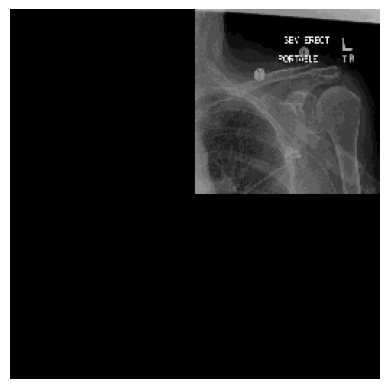

Epoch 1/4
169/169 [==============================] - 534s 3s/step - loss: 0.7558 - accuracy: 0.6839 - val_loss: 0.5578 - val_accuracy: 0.7858
Epoch 2/4
169/169 [==============================] - 486s 3s/step - loss: 0.5789 - accuracy: 0.7484 - val_loss: 0.5025 - val_accuracy: 0.8005
Epoch 3/4
169/169 [==============================] - 531s 3s/step - loss: 0.5155 - accuracy: 0.7813 - val_loss: 0.4424 - val_accuracy: 0.8144
Epoch 4/4
37/37 [==============================] - 38s 1s/step - loss: 0.4322 - accuracy: 0.8224
Test accuracy: 0.8224
========== 右下128 ==========


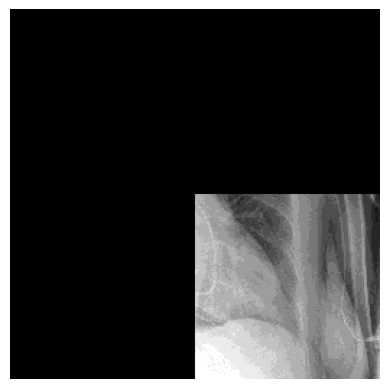

Epoch 1/4
169/169 [==============================] - 533s 3s/step - loss: 0.9453 - accuracy: 0.5864 - val_loss: 0.8276 - val_accuracy: 0.6583
Epoch 2/4
169/169 [==============================] - 423s 2s/step - loss: 0.8358 - accuracy: 0.6371 - val_loss: 0.7865 - val_accuracy: 0.6565
Epoch 3/4
169/169 [==============================] - 2310s 14s/step - loss: 0.8140 - accuracy: 0.6535 - val_loss: 0.7959 - val_accuracy: 0.6557
Epoch 4/4
37/37 [==============================] - 28s 762ms/step - loss: 0.7564 - accuracy: 0.6846
Test accuracy: 0.6846
========== 中間128 ==========


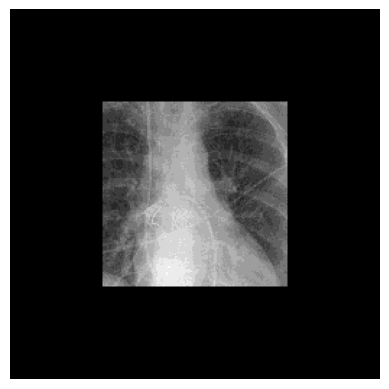

Epoch 1/4
169/169 [==============================] - 403s 2s/step - loss: 0.7954 - accuracy: 0.6795 - val_loss: 0.6459 - val_accuracy: 0.7511
Epoch 2/4
169/169 [==============================] - 402s 2s/step - loss: 0.6807 - accuracy: 0.7235 - val_loss: 0.6076 - val_accuracy: 0.7693
Epoch 3/4
169/169 [==============================] - 1337s 8s/step - loss: 0.6536 - accuracy: 0.7354 - val_loss: 0.6117 - val_accuracy: 0.7745
Epoch 4/4
37/37 [==============================] - 36s 966ms/step - loss: 0.6559 - accuracy: 0.7314
Test accuracy: 0.7314


In [20]:
#create_data,extract_certain_subarray_with_mask,extract_random_subarray_with_mask
for data in data_list:
    print("========== "+data[0]+" ==========")
    #image_list_now ,zip_list_now =create_certain_data(zip_filt_list, image_load_list, extract_certain_subarray_with_mask, data[1], data[2], data[3])
    zip_list_now = []
    image_list_now = []
    for i in range(len(zip_filt_list)):
        if zip_filt_list[i] == 4 or zip_filt_list[i] == 9 or zip_filt_list[i] == 1:
            if zip_filt_list[i] == 4:
                zip_list_now.append(0)
                four.append(np.uint8(image_load_list[i]))
            if zip_filt_list[i] == 1:
                zip_list_now.append(1)
                one.append(np.uint8(image_load_list[i]))
            if zip_filt_list[i] == 9:
                zip_list_now.append(2)
                nine.append(np.uint8(image_load_list[i]))
            image_list_now.append( np.uint8(extract_certain_subarray_with_mask(image_load_list[i],data[1], data[2], data[3])))
            #image_list_now.append( np.uint8(extract_certain_subarray_with_mask(image_load_list[i], data[4], data[5], data[6])))
    draw_CR(image_list_now[0])
    X = np.array(image_list_now) 
    X = X.reshape((-1, 256, 256, 1)) 
    y = to_categorical(zip_list_now, num_classes=3)  

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    model_ResNet50 = build_model()
    model_ResNet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model_ResNet50.fit(X_train, y_train, epochs=4, validation_data=(X_val, y_val))
    test_loss, test_acc = model_ResNet50.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_acc:.4f}")     

In [21]:
data_list = [
    ["左上100 ",0,0,100],
    ["左下100",156,0,100],
    ["右上100",0,156,100],
    ["右下100",156,156,100],
    ["中間100",78,78,100],
]
model_list = []
Test_accuracy_list = []

========== 左上100  ==========


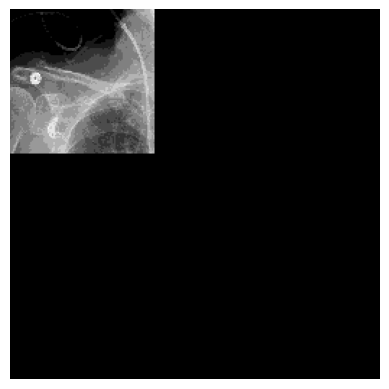

Epoch 1/4
169/169 [==============================] - 515s 3s/step - loss: 0.8673 - accuracy: 0.6394 - val_loss: 0.7074 - val_accuracy: 0.6921
Epoch 2/4
169/169 [==============================] - 531s 3s/step - loss: 0.7065 - accuracy: 0.7109 - val_loss: 0.6140 - val_accuracy: 0.7441
Epoch 3/4
169/169 [==============================] - 533s 3s/step - loss: 0.6605 - accuracy: 0.7202 - val_loss: 0.5671 - val_accuracy: 0.7693
Epoch 4/4
37/37 [==============================] - 29s 778ms/step - loss: 0.6033 - accuracy: 0.7444
Test accuracy: 0.7444
========== 左下100 ==========


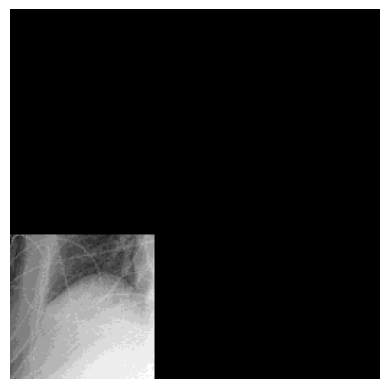

Epoch 1/4
169/169 [==============================] - 411s 2s/step - loss: 0.9507 - accuracy: 0.5712 - val_loss: 0.8373 - val_accuracy: 0.6349
Epoch 2/4
169/169 [==============================] - 398s 2s/step - loss: 0.8621 - accuracy: 0.6154 - val_loss: 0.7926 - val_accuracy: 0.6722
Epoch 3/4
169/169 [==============================] - 396s 2s/step - loss: 0.8412 - accuracy: 0.6241 - val_loss: 0.7896 - val_accuracy: 0.6652
Epoch 4/4
37/37 [==============================] - 28s 760ms/step - loss: 0.7852 - accuracy: 0.6655
Test accuracy: 0.6655
========== 右上100 ==========


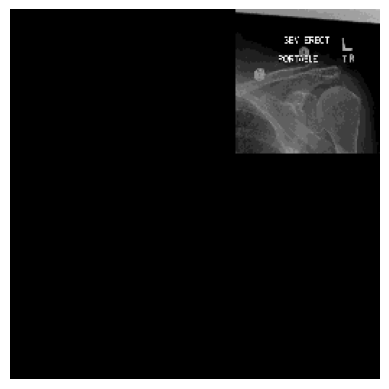

Epoch 1/4
169/169 [==============================] - 4223s 25s/step - loss: 0.8972 - accuracy: 0.6213 - val_loss: 0.7319 - val_accuracy: 0.6999
Epoch 2/4
169/169 [==============================] - 488s 3s/step - loss: 0.7379 - accuracy: 0.6973 - val_loss: 0.6624 - val_accuracy: 0.7355
Epoch 3/4
169/169 [==============================] - 509s 3s/step - loss: 0.6825 - accuracy: 0.7209 - val_loss: 0.6156 - val_accuracy: 0.7520
Epoch 4/4
37/37 [==============================] - 39s 1s/step - loss: 0.6431 - accuracy: 0.7487
Test accuracy: 0.7487
========== 右下100 ==========


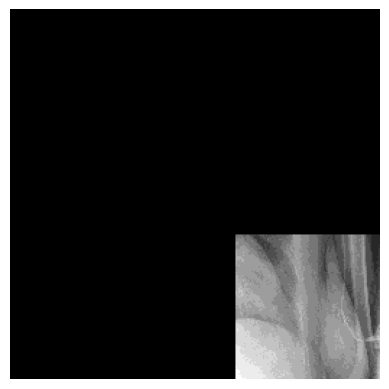

Epoch 1/4
169/169 [==============================] - 532s 3s/step - loss: 0.9600 - accuracy: 0.5669 - val_loss: 0.8462 - val_accuracy: 0.6210
Epoch 2/4
169/169 [==============================] - 554s 3s/step - loss: 0.8584 - accuracy: 0.6265 - val_loss: 0.8760 - val_accuracy: 0.5854
Epoch 3/4
169/169 [==============================] - 558s 3s/step - loss: 0.8201 - accuracy: 0.6485 - val_loss: 0.8016 - val_accuracy: 0.6557
Epoch 4/4
37/37 [==============================] - 36s 973ms/step - loss: 0.7539 - accuracy: 0.6958
Test accuracy: 0.6958
========== 中間100 ==========


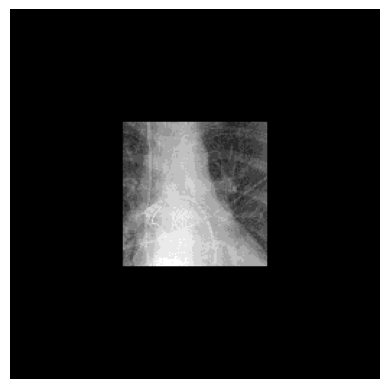

Epoch 1/4
169/169 [==============================] - 507s 3s/step - loss: 0.8345 - accuracy: 0.6540 - val_loss: 0.6991 - val_accuracy: 0.7346
Epoch 2/4
169/169 [==============================] - 520s 3s/step - loss: 0.7252 - accuracy: 0.6997 - val_loss: 0.6725 - val_accuracy: 0.7424
Epoch 3/4
169/169 [==============================] - 540s 3s/step - loss: 0.7022 - accuracy: 0.7066 - val_loss: 0.6333 - val_accuracy: 0.7572
Epoch 4/4
37/37 [==============================] - 30s 824ms/step - loss: 0.6533 - accuracy: 0.7288
Test accuracy: 0.7288


In [26]:
#create_data,extract_certain_subarray_with_mask,extract_random_subarray_with_mask
for data in data_list:
    print("========== "+data[0]+" ==========")
    #image_list_now ,zip_list_now =create_certain_data(zip_filt_list, image_load_list, extract_certain_subarray_with_mask, data[1], data[2], data[3])
    zip_list_now = []
    image_list_now = []
    for i in range(len(zip_filt_list)):
        if zip_filt_list[i] == 4 or zip_filt_list[i] == 9 or zip_filt_list[i] == 1:
            if zip_filt_list[i] == 4:
                zip_list_now.append(0)
                four.append(np.uint8(image_load_list[i]))
            if zip_filt_list[i] == 1:
                zip_list_now.append(1)
                one.append(np.uint8(image_load_list[i]))
            if zip_filt_list[i] == 9:
                zip_list_now.append(2)
                nine.append(np.uint8(image_load_list[i]))
            image_list_now.append( np.uint8(extract_certain_subarray_with_mask(image_load_list[i],data[1], data[2], data[3])))
            #image_list_now.append( np.uint8(extract_certain_subarray_with_mask(image_load_list[i], data[4], data[5], data[6])))
    draw_CR(image_list_now[0])
    X = np.array(image_list_now) 
    X = X.reshape((-1, 256, 256, 1)) 
    y = to_categorical(zip_list_now, num_classes=3)  

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    model_ResNet50 = build_model()
    model_ResNet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model_ResNet50.fit(X_train, y_train, epochs=4, validation_data=(X_val, y_val))
    test_loss, test_acc = model_ResNet50.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_acc:.4f}")                                                                                 

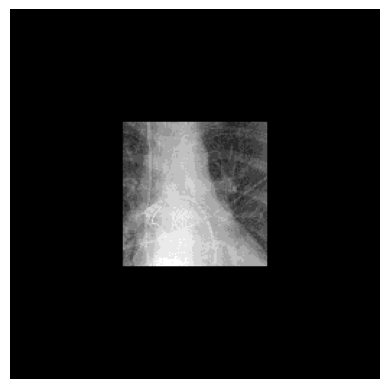

In [27]:
draw_CR(image_list_now[0])